In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from collections import Counter
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
import os

In [2]:
train_path = os.path.join(os.getcwd(), 'data', 'train.txt')
test_path = os.path.join(os.getcwd(), 'data', 'test.txt')
val_path = os.path.join(os.getcwd(), 'data', 'val.txt')

In [3]:
train_data = pd.read_csv(os.path.join(os.curdir, 'data', 'train.txt'), header=None, sep=';', names=[
                         'text', 'emotion'], encoding='utf-8')
test_data = pd.read_csv(os.path.join(os.curdir, 'data', 'test.txt'), header=None, sep=';', names=[
                        'text', 'emotion'], encoding='utf-8')
val_data = pd.read_csv(os.path.join(os.curdir, 'data', 'val.txt'), header=None, sep=';', names=[
                       'text', 'emotion'], encoding='utf-8')

In [4]:
train_data.head()

,text,emotion
0,i didnt feel terrified,fear
1,i even feel it is a game that i am a part of s...,surprise
2,i was starting to feel a little stressed,sadness
3,i feel so glad,joy
4,i just feel so inadequate today,sadness


In [5]:
train_data['emotion'].value_counts()

emotion
joy         53911
sadness     46358
anger       21294
fear        19377
love        13040
surprise     5710
Name: count, dtype: int64

In [6]:
train_data.duplicated().sum()

143721

In [8]:
class EmotionData:
    def __init__(self, train_data_path, test_data_path, val_data_path, vocb_coverage=0.9, max_len_qnt=1, max_len_buffer=25):
        self.train_data = self._load_data(train_data_path)
        self.test_data = self._load_data(test_data_path)
        self.val_data = self._load_data(val_data_path)
        self.label_encoder = LabelEncoder().fit(self.train_data['emotion'])
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
        self.vocab_size = self._calculate_vocab_size(vocb_coverage)
        self.max_length = self._calculate_max_length(
            max_len_qnt, max_len_buffer)
        self.nr_classes = len(self.train_data['emotion'].unique())
        self.tokenizer = Tokenizer(num_words=self.vocab_size, oov_token="<OOV>",
                                   lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
        self.tokenizer.fit_on_texts(
            self.train_data['text'].apply(self._preprocess_text))

    def _calculate_vocab_size(self, vocb_coverage):
        words = ''.join(self.train_data['text'].apply(
            lambda x: re.sub("[^a-zA-Z0-9]", " ", x).lower())).split()
        word_freq = Counter(words)

        total_words = sum(word_freq.values())
        cum_coverage = 0
        vocab_size = 0

        for _, cnt in word_freq.most_common():
            cum_coverage += cnt / total_words
            vocab_size += 1
            if cum_coverage >= vocb_coverage:
                break

        return vocab_size

    def _calculate_max_length(self, max_len_qnt, max_len_buffer):
        return int(self.train_data['length'].quantile(max_len_qnt)) + max_len_buffer

    def _load_data(self, path):
        data = pd.read_csv(path, header=None, sep=';', names=[
                           'text', 'emotion'], encoding='utf-8')
        data.drop_duplicates(subset=['text', 'emotion'], inplace=True)
        data.dropna(inplace=True)
        data['length'] = data['text'].apply(lambda x: len(x.split()))
        return data

    def _preprocess_text(self, text):
        words = re.sub("[^a-zA-Z0-9]", " ", text).lower().split()
        words = [self.stemmer.stem(word)
                 for word in words if word not in self.stop_words]
        return ' '.join(words)

    def _process_input(self, input: str):
        preprocessed_text = self._preprocess_text(input)
        sequences = self.tokenizer.texts_to_sequences([preprocessed_text])
        padded_sequence = pad_sequences(
            sequences, maxlen=self.max_length, padding='pre')

        return padded_sequence[0]

    def clean_single_text(self, text: str):
        return self._process_input(text).reshape(1, -1)

    def clean_text(self, df: pd.DataFrame, text_col: str):
        return np.array([self._process_input(text) for text in df[text_col]])

    def get_labels(self, df: pd.DataFrame, label_col: str):
        return to_categorical(self.label_encoder.transform(df[label_col]))

    def predict_emotion(self, model, text: str):
        result = {}
        sentence = self.clean_single_text(text)
        prediction = model.predict(sentence)
        for i in range(len(prediction[0])):
            result[self.label_encoder.inverse_transform(
                [i])[0]] = prediction[0][i]
        return result

In [10]:
emotion_data = EmotionData(train_path, test_path, val_path)
all_text = emotion_data.train_data['text'].astype(str)
words = ''.join(emotion_data.train_data['text'].apply(
    lambda x: re.sub("[^a-zA-Z0-9]", " ", x).lower())).split()
words = [w for w in words if w not in emotion_data.stop_words]
word_freq = Counter(words)
word_freq.items()
print(emotion_data.vocab_size)
emotion_data.clean_text(emotion_data.train_data, 'text')

2853


array([[   0,    0,    0, ...,   58,    2,  329],
       [   0,    0,    0, ...,    1,  122,    8],
       [   0,    0,    0, ...,    2,   13,  113],
       ...,
       [   0,    0,    0, ...,  447,  447,  561],
       [   0,    0,    0, ...,    2,   55,  169],
       [   0,    0,    0, ...,   15, 1358, 1263]])

In [27]:
emotion_data = EmotionData(train_path, test_path, val_path)
EPOCHS = 50
BATCH_SIZE = 32

METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(os.curdir, 'models', 'tamp.h5'), monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.25, patience=3, mode='auto', min_lr=1e-5)
]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(emotion_data.max_length,)),
    tf.keras.layers.Embedding(input_dim=emotion_data.vocab_size,
                              output_dim=150, input_length=emotion_data.max_length),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.1)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(128, return_sequences=True, dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(1e-6))),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(emotion_data.nr_classes, activation='softmax')
])

tf.random.set_seed(42)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)

In [19]:
X_train, Y_train = emotion_data.clean_text(
    emotion_data.train_data, 'text'), emotion_data.get_labels(emotion_data.train_data, 'emotion')

In [21]:
X_train.shape, Y_train.shape

((15969, 91), (15969, 6))

In [22]:
X_val, Y_val = emotion_data.clean_text(
    emotion_data.val_data, 'text'), emotion_data.get_labels(emotion_data.val_data, 'emotion')

In [23]:
X_val.shape, Y_val.shape

((2000, 91), (2000, 6))

In [24]:
emotion_data.nr_classes

6

In [28]:
history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    callbacks=callbacks, validation_data=(X_val, Y_val))

Epoch 1/50
500/500 [==============================] - 48s 77ms/step - loss: 0.9232 - accuracy: 0.6510 - precision: 0.8446 - recall: 0.5067 - auc: 0.9130 - val_loss: 0.3449 - val_accuracy: 0.8800 - val_precision: 0.8957 - val_recall: 0.8635 - val_auc: 0.9880 - lr: 0.0010
Epoch 2/50
500/500 [==============================] - 36s 71ms/step - loss: 0.2198 - accuracy: 0.9156 - precision: 0.9259 - recall: 0.9071 - auc: 0.9943 - val_loss: 0.2267 - val_accuracy: 0.9045 - val_precision: 0.9122 - val_recall: 0.8990 - val_auc: 0.9930 - lr: 0.0010
Epoch 3/50
500/500 [==============================] - 35s 70ms/step - loss: 0.1502 - accuracy: 0.9406 - precision: 0.9451 - recall: 0.9363 - auc: 0.9972 - val_loss: 0.2260 - val_accuracy: 0.9160 - val_precision: 0.9209 - val_recall: 0.9075 - val_auc: 0.9925 - lr: 0.0010
Epoch 4/50
500/500 [==============================] - 36s 72ms/step - loss: 0.1159 - accuracy: 0.9529 - precision: 0.9568 - recall: 0.9497 - auc: 0.9983 - val_loss: 0.2613 - val_accuracy:

In [29]:
from keras.models import load_model
loaded_model = load_model(os.path.join(os.curdir, 'models', 'tamp.h5'))
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 91, 150)           427950    
                                                                 
 bidirectional_3 (Bidirectio  (None, 91, 256)          285696    
 nal)                                                            
                                                                 
 layer_normalization_3 (Laye  (None, 91, 256)          512       
 rNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 91, 256)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 91, 256)          296448    
 nal)                                                            
                                                      

In [30]:
sentence = emotion_data.clean_single_text('happy and joyful')
result = emotion_data.label_encoder.inverse_transform(
    np.argmax(model.predict(sentence), axis=1))[0]
prob = np.max(model.predict(sentence))
print(f"{result} with probability of {prob}")

1/1 [==============================] - 0s 31ms/step
joy with probability of 0.8961552977561951


In [31]:
import matplotlib.pyplot as plt
import json


class CustomHistory:

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # culori

    def __init__(self, history):
        self.history = history.history
        self.epoch = history.epoch
        self.params = history.params

    def save(self, path):
        """
        Salveaza istoria modelului in fisiere json
        :param path: Calea de baza pentru salvarea fisierelor
        :return: void
        """
        history_to_save = {}
        for key, values in self.history.items():
            history_to_save[key] = [float(value) for value in values]
        with open(f"{path}_history.json", 'w') as file:
            json.dump(history_to_save, file)
        with open(f"{path}_epoch.json", 'w') as file:
            json.dump(self.epoch, file)
        with open(f"{path}_params.json", 'w') as file:
            json.dump(self.params, file)

    @staticmethod
    def load(path):
        """
        Incarca istoria modelului din fisiere json
        :param path: Cala de baza pentru incarcarea fisierelor
        :return: CustomHistory cu istoria modelului
        """
        with open(f"{path}_history.json", 'r') as file:
            history = json.load(file)
        with open(f"{path}_epoch.json", 'r') as file:
            epoch = json.load(file)
        with open(f"{path}_params.json", 'r') as file:
            params = json.load(file)
        # Creating a dummy class to mimic what might be expected by CustomHistory constructor
        dummy_history = type('DummyHistory', (), {
                             'history': history, 'epoch': epoch, 'params': params})()
        return CustomHistory(dummy_history)

    def plot_loss(self,  n: int = 0):
        """
        Functie pentru a plota lossul modelului
        :param n: Indicele culorii
        :return: void
        """
        plt.figure(figsize=(15, 10))
        plt.semilogy(self.epoch, self.history['loss'],
                     color=CustomHistory.colors[n], label='Train Loss')
        plt.semilogy(self.epoch, self.history['val_loss'],
                     color=CustomHistory.colors[n], label='Val Loss',
                     linestyle="--")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    def plot_metrics(self, metrics=[], figsize=(20, 15)):
        """
        Functie pentru a plota metricile modelului
        :param metrics: Lista cu numele metricilor
        :param figsize: Dimensiunea figurii din matplotlib
        :return: void
        """
        plt.figure(figsize=figsize)
        for n, metric in enumerate(metrics):
            name = metric.replace("_", " ").capitalize()
            plt.subplot(len(metrics), 2, n+1)
            plt.plot(self.epoch,
                     self.history[metric], color=CustomHistory.colors[0], label='Train')
            plt.plot(self.epoch, self.history['val_'+metric],
                     color=CustomHistory.colors[1], linestyle="--", label='Val')
            plt.xlabel('Epoch')
            plt.ylabel(name)
            if metric == 'loss':
                plt.ylim([0, plt.ylim()[1]])
            elif metric == 'auc':
                plt.ylim([0.8, 1])
            else:
                plt.ylim([0, 1])
            plt.legend()

In [36]:
CustomHistory(history).save(os.path.join(os.curdir, "history", "history"))
loaded_history = CustomHistory.load(
    os.path.join(os.curdir, "history", "history"))

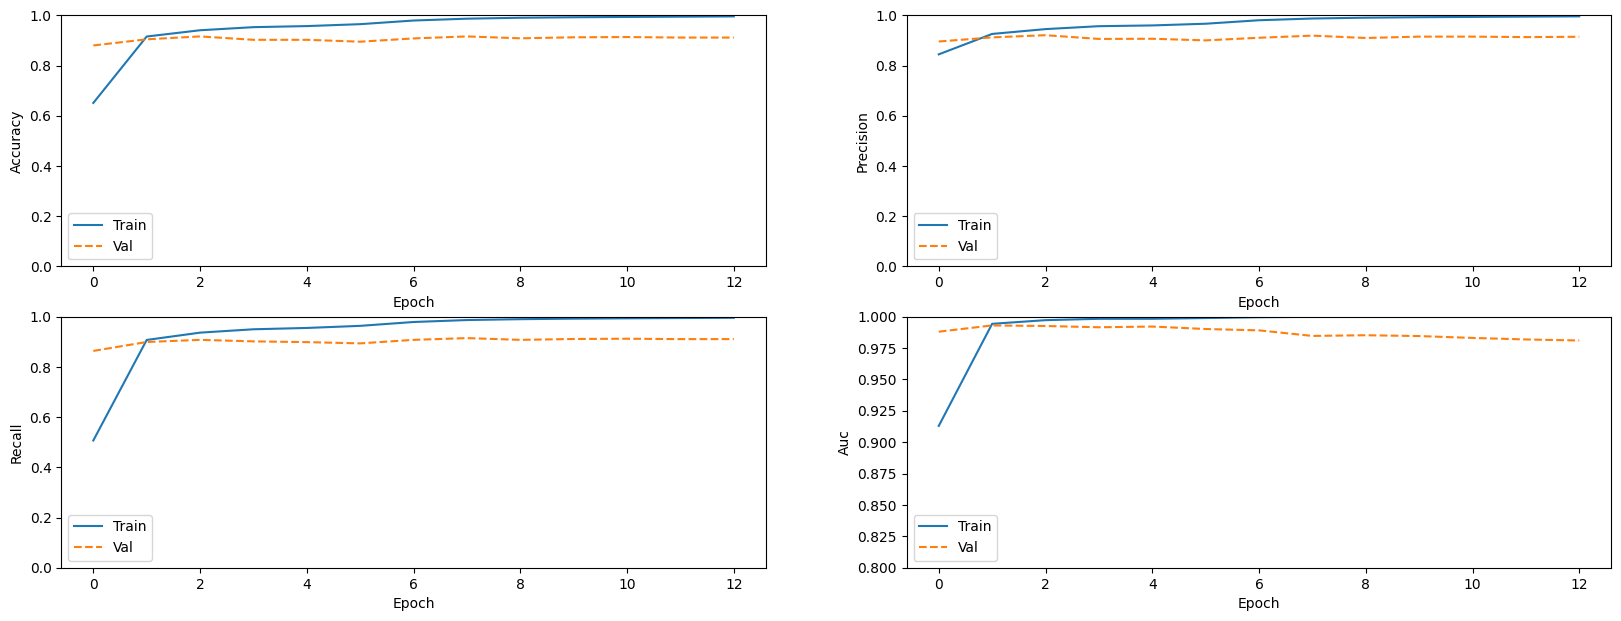

In [37]:
loaded_history.plot_metrics([m.name for m in METRICS])

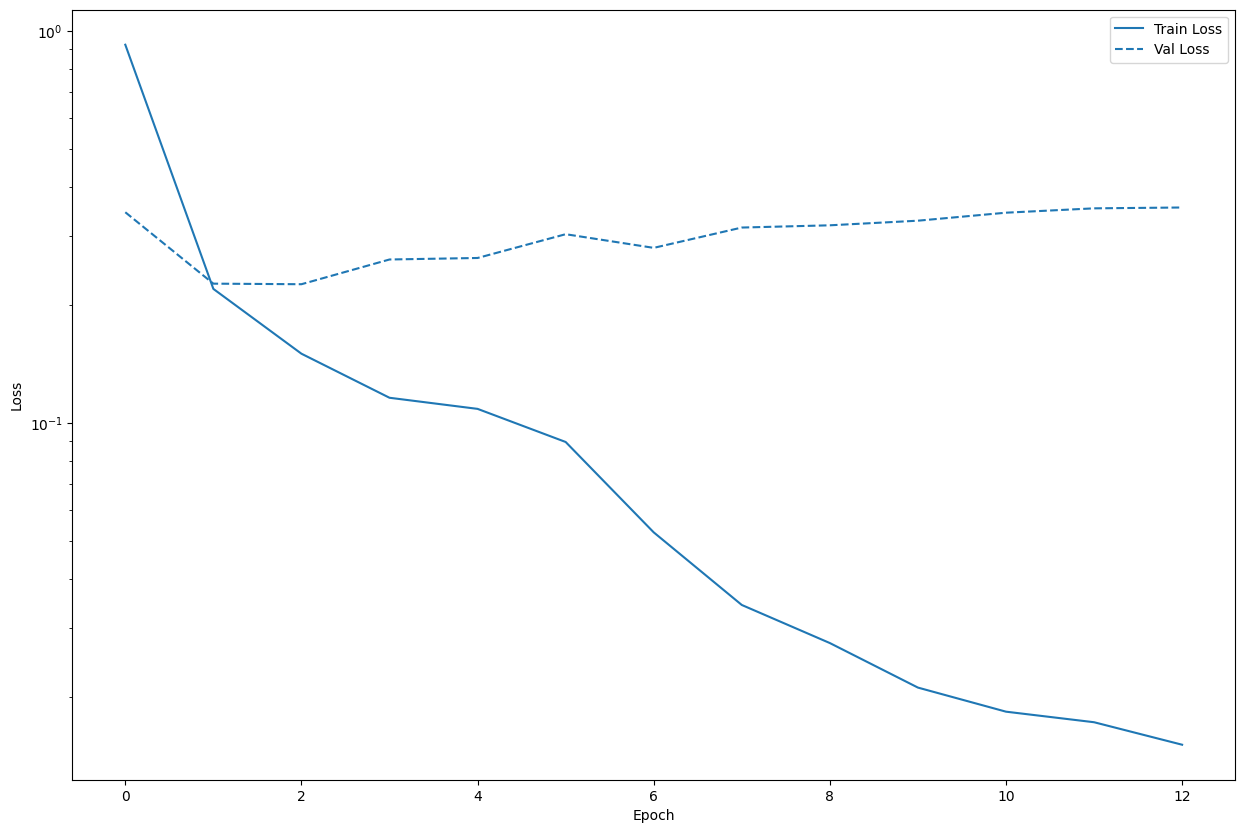

In [38]:
loaded_history.plot_loss()

In [39]:
def get_metrics(model, X_test, Y_test):
    """
    Functie pentru a obtine metricile modelului
    :param model:  Modelul antrenat din tensorflow
    :return: void
    """
    metrics_names = ["loss"]+[m.name for m in METRICS]
    results = model.evaluate(X_test, Y_test,
                             batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(metrics_names, results):
        print(name, ': ', value)

In [40]:
X_test, Y_test = emotion_data.clean_text(
    emotion_data.test_data, 'text'), emotion_data.get_labels(emotion_data.test_data, 'emotion')

In [41]:
get_metrics(model, X_test, Y_test)

loss :  0.2441266030073166
accuracy :  0.9070000052452087
precision :  0.9117498993873596
recall :  0.9039999842643738
auc :  0.9928426146507263


In [ ]:
import joblib
joblib.dump(emotion_data.label_encoder, os.path.join(
    os.curdir, 'models', 'label_encoder.pkl'))
loaded_le = joblib.load(os.path.join(os.curdir, 'models', 'label_encoder.pkl'))

In [43]:
emotion_data.predict_emotion(
    loaded_model, "The staff: made my stay in hospital much more bearable, cheering me up when i was having a bad day! I would like to say a massive thank you to everyone in Ward 4a,")

1/1 [==============================] - 2s 2s/step


{'anger': 0.1931343,
 'fear': 0.04520174,
 'joy': 0.72202146,
 'love': 0.0017103453,
 'sadness': 0.036638454,
 'surprise': 0.0012937004}

In [45]:
medical_data = pd.read_csv(os.path.join(os.curdir, 'data', 'realistic_biomedical_clinical_emotion_dataset.csv'), sep=',', names=[
                           'text', 'emotion'], encoding='utf-8')
medical_data

,text,emotion
0,The entire experience left me feeling down and...,sadness
1,The staff were so rude during our stay. We fel...,anger
2,The staff were so rude during our stay. We fel...,anger
3,"Everything was explained clearly, which gave m...",calmness
4,Everything was handled with such care; I felt ...,pleasantness
...,...,...
1995,The staff were kind and always willing to help...,pleasantness
1996,Everything was handled with such care; I felt ...,pleasantness
1997,Everything was handled with such care; I felt ...,pleasantness
1998,I couldn’t be happier with the treatment and c...,joy


In [46]:
medical_data['emotion'].value_counts()

emotion
sadness         413
pleasantness    396
fear            288
eagerness       205
joy             201
anger           197
calmness        192
disgust         108
Name: count, dtype: int64

In [ ]:
def clean_text(df: pd.DataFrame, column: str, vocab_size: int, max_length: int):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    tokenizer = emotion_data.tokenizer
    dex = []
    for text in df[column]:
        text = re.sub("[^a-zA-Z0-9]", " ", text).lower().split()
        text = [stemmer.stem(word)
                for word in text if word not in stop_words]
        text = ' '.join(text)
        dex.append(text)
    sequences = tokenizer.texts_to_sequences(dex)
    padded_sequence = pad_sequences(
        sequences, maxlen=max_length, padding='pre')
    return padded_sequence


bio_label = LabelEncoder().fit(medical_data['emotion'])

In [54]:
emotion_data.vocab_size, emotion_data.max_length

(2853, 91)

In [ ]:
X_bio_train, Y_bio_train = clean_text(
    medical_data, 'text', emotion_data.vocab_size, emotion_data.max_length), to_categorical(bio_label.transform(medical_data['emotion']))

In [56]:
X_bio_train.shape, Y_bio_train.shape

((2000, 91), (2000, 8))

In [57]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 91, 150)           427950    
                                                                 
 bidirectional_3 (Bidirectio  (None, 91, 256)          285696    
 nal)                                                            
                                                                 
 layer_normalization_3 (Laye  (None, 91, 256)          512       
 rNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 91, 256)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 91, 256)          296448    
 nal)                                                            
                                                      

In [58]:
num_classes = len(medical_data['emotion'].unique())
num_classes

8

In [60]:
bio_model = load_model(os.path.join(os.curdir, 'models', 'tamp.h5'))
bio_model.layers[-1] = tf.keras.layers.Dense(8, activation='softmax')
for layer in bio_model.layers[:-2]:
    layer.trainable = False
bio_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=METRICS)

bio_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 91, 150)           427950    
                                                                 
 bidirectional_3 (Bidirectio  (None, 91, 256)          285696    
 nal)                                                            
                                                                 
 layer_normalization_3 (Laye  (None, 91, 256)          512       
 rNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 91, 256)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 91, 256)          296448    
 nal)                                                            
                                                      

In [61]:
from keras.models import Model
bio_model = Model(inputs=loaded_model.input,
                  outputs=loaded_model.layers[-2].output)
bio_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 91)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 91, 150)           427950    
                                                                 
 bidirectional_3 (Bidirectio  (None, 91, 256)          285696    
 nal)                                                            
                                                                 
 layer_normalization_3 (Laye  (None, 91, 256)          512       
 rNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 91, 256)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 91, 256)          296448

In [62]:
new_output = tf.keras.layers.Dense(
    num_classes, activation='softmax')(bio_model.output)
new_model = Model(inputs=bio_model.input, outputs=new_output)
for layer in new_model.layers[:-2]:
    layer.trainable = False
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=METRICS)

new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 91)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 91, 150)           427950    
                                                                 
 bidirectional_3 (Bidirectio  (None, 91, 256)          285696    
 nal)                                                            
                                                                 
 layer_normalization_3 (Laye  (None, 91, 256)          512       
 rNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 91, 256)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 91, 256)          2964

In [ ]:
bio_callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(os.curdir, 'models', 'bio_model.h5'), monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.25, patience=3, mode='auto', min_lr=1e-5)
]

In [64]:
new_model.fit(X_bio_train, Y_bio_train, epochs=250, batch_size=BATCH_SIZE,
              callbacks=bio_callback, validation_split=0.2)

Epoch 1/250
50/50 [==============================] - 13s 102ms/step - loss: 1.9703 - accuracy: 0.6628 - precision: 0.8877 - recall: 0.5161 - auc: 0.9086 - val_loss: 1.2332 - val_accuracy: 0.6300 - val_precision: 1.0000 - val_recall: 0.1725 - val_auc: 0.9276 - lr: 0.0010
Epoch 2/250
50/50 [==============================] - 3s 57ms/step - loss: 1.1370 - accuracy: 0.7156 - precision: 0.9651 - recall: 0.2763 - auc: 0.9318 - val_loss: 0.8213 - val_accuracy: 0.8350 - val_precision: 1.0000 - val_recall: 0.5800 - val_auc: 0.9738 - lr: 0.0010
Epoch 3/250
50/50 [==============================] - 4s 76ms/step - loss: 0.8005 - accuracy: 0.8000 - precision: 0.9389 - recall: 0.5663 - auc: 0.9735 - val_loss: 0.5640 - val_accuracy: 0.8675 - val_precision: 1.0000 - val_recall: 0.6800 - val_auc: 0.9925 - lr: 0.0010
Epoch 4/250
50/50 [==============================] - 6s 126ms/step - loss: 0.5812 - accuracy: 0.8606 - precision: 0.9444 - recall: 0.7000 - auc: 0.9905 - val_loss: 0.3924 - val_accuracy: 0.93

In [ ]:
def predict_emotion(model, text: str):
    result = {}
    sentence = clean_text(pd.DataFrame(
        {'text': [text]}), 'text', emotion_data.vocab_size, emotion_data.max_length)
    prediction = model.predict(sentence)
    for i in range(len(prediction[0])):
        result[bio_label.inverse_transform(
            [i])[0]] = prediction[0][i]
    return result

In [77]:
clean_text(pd.DataFrame({'text': ["The staff: made my stay in hospital much more bearable, cheering me up when i was having a bad day! I would like to say a massive thank you to everyone in Ward 4a,"]}), 'text', emotion_data.vocab_size, emotion_data.max_length)

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 2147,   53,  257,
        1641,   28,    1, 1016,  131,   15,   19,    3,   32, 2026,  139,
         170, 2829,    1]])

In [74]:
predict_emotion(new_model, "The staff: made my stay in hospital much more bearable, cheering me up when i was having a bad day! I would like to say a massive thank you to everyone in Ward 4a,")

1/1 [==============================] - 0s 34ms/step


{'anger': 0.060415212,
 'calmness': 0.00073833246,
 'disgust': 0.17531173,
 'eagerness': 0.0025177447,
 'fear': 0.20129168,
 'joy': 0.5590164,
 'pleasantness': 0.00013993912,
 'sadness': 0.00056888274}

In [68]:
import joblib
joblib.dump(bio_label, os.path.join(
    os.curdir, 'models', 'bio_label_encoder.pkl'))
loaded_le = joblib.load(os.path.join(
    os.curdir, 'models', 'bio_label_encoder.pkl'))

In [ ]:
import json
with open(os.path.join(os.curdir, 'models', 'bio_sizes.json'), 'w') as file:
    json.dump({'vocab_size': emotion_data.vocab_size,
              'max_length': emotion_data.max_length, 'num_classes': num_classes}, file)
with open(os.path.join(os.curdir, 'models', 'bio_tokenizer.json'), 'w') as file:
    file.write(emotion_data.tokenizer.to_json())

In [76]:
os.curdir

'.'